## Building a CNN on Fashion MNIST

This notebook demonstrates how a data scientist would approach exploring a dataset, building a model, and saving that model within a workflow utilizing [Quilt T4](https://quiltdocs.gitbook.io/t4/).

We will build a convolutional neural network based on the [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist) dataset. Fashion MNIST is an image dataset curated by the folks at Zalando Research specifically for the purpose of providing a good default dataset for use in image classification tasks. It consists of a moderately large set of 28x28 images of various fashion items, which have been assigned to one of ten different classes. This dataset is useful for benchmarking image classification challenges, as it is significantly harder than the extremely well-known MNIST dataset, whilst still being easy enough that relatively straightforward image classification techniques may be used to solve it. Classification of clothing (for the purposes of recommendation) is a very well-traveled problem in startups these days, and this well-curated dataset is a great introduction to this problem.

We'll cover the full workflow typical for a data scientist: exploration, model training, model evaluation, and then saving that model. We'll see how T4 can help with saving the dataset and saving the model remotely.

To learn more, read the complimentary blog post: `[STILL FORTHCOMING]`.

## Getting the data

The first step to building a model is actually getting the data. For the purposes of this example notebook we'll just load the data off of disk, for now.

In [1]:
import numpy as np
import pandas as pd

data_train = pd.read_csv('fashion-mnist_train.csv')
# data_test = pd.read_csv('../input/fashion-mnist_train.csv')

In [2]:
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exploring the data

There are 10 unique classes in the dataset.

In [3]:
sorted(data_train.label.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

If we plot these out we can see what they are.

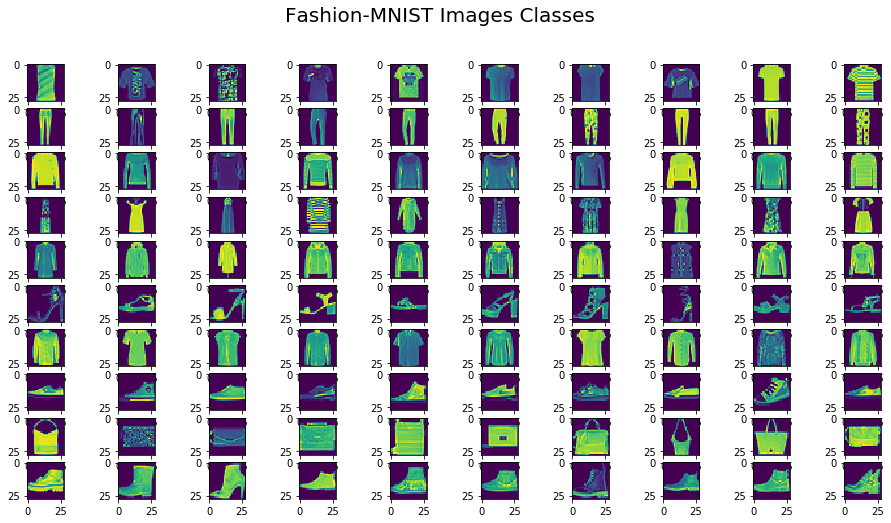

In [4]:
%matplotlib inline

labels = sorted(data_train.label.unique())
n_samples = 10

import matplotlib.pyplot as plt
fig, axarr = plt.subplots(len(labels), n_samples, figsize=(16, 8))

for j, label in enumerate(labels):
    for k, img_arr in enumerate(data_train.query("label == @label").sample(n_samples, random_state=42)\
                                    .values[:, 1:].reshape((n_samples, 28, 28))):
        axarr[j][k].imshow(img_arr)

fig.suptitle("Fashion-MNIST Images Classes", fontsize=20)
pass

We can back this out into explicit class names:

In [5]:
img_class_key = {
    0: 't-shirt',
    1: 'pants',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneakers',
    8: 'handbag',
    9: 'boot'
}

This dataset is completely balanced: every class appears in the dataset the same number of times, exactly 6000. This is great because it prevents using from running into any problems with having to perform [imbalanced learning](https://towardsdatascience.com/dealing-with-imbalanced-classes-in-machine-learning-d43d6fa19d2).

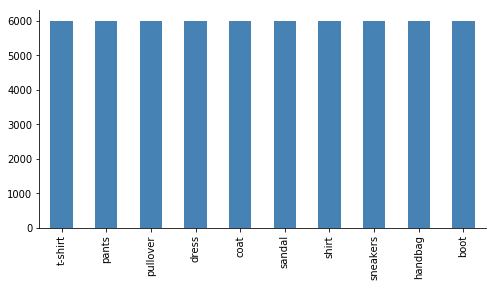

In [6]:
import seaborn as sns
label_counts = data_train['label'].value_counts()
label_counts.index = img_class_key.values()
label_counts.plot.bar(color='steelblue', figsize=(8, 4))
sns.despine()
pass

## Training a model

For the purposes of demonstration, let's train a CNN model on this dataset. CNNs provide the current bleeding edge of performance on these kinds of image classification problems. If you are unfamiliar with CNNs, [this blog post](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) provides a good conceptual overview.

In [7]:
# exclude the class label from the training data, otherwise we have nothing to train on
X = data_train.iloc[:, 1:].values

# one-hot encode the classes
y = pd.get_dummies(data_train.iloc[:, 0].values).values

# partition the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the flat [0, 255]-entry list into a [0, 1]-entry grid, as desired by the CNN.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float') / 255

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

clf = Sequential()
clf.add(Conv2D(32, kernel_size=(3, 3),
               activation='relu',
               kernel_initializer='he_normal',
               input_shape=(28, 28, 1)))
clf.add(MaxPooling2D((2, 2)))
clf.add(Dropout(0.25))
clf.add(Conv2D(64, (3, 3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))
clf.add(Dropout(0.25))
clf.add(Conv2D(128, (3, 3), activation='relu'))
clf.add(Dropout(0.4))
clf.add(Flatten())
clf.add(Dense(128, activation='relu'))
clf.add(Dropout(0.3))
clf.add(Dense(10, activation='softmax'))

clf.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

Using TensorFlow backend.


In [10]:
%%time

# TODO: using epochs=1 temporarily! Go back to 30 eventually.
history = clf.fit(X_train, y_train, batch_size=512, epochs=1, verbose=1, validation_data=(X_test, y_test))

Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 80s 2ms/step - loss: 0.6337 - acc: 0.7603 - val_loss: 0.4991 - val_acc: 0.8179
CPU times: user 2min 41s, sys: 2.58 s, total: 2min 43s
Wall time: 1min 19s


## Evaluating model performance

To evaluate model performance, let's start by looking at the training accuracy and validation accuracy over training epochs. If we did a good job training our model the training and validation accuracy and loss will both be similar monotonic curves.

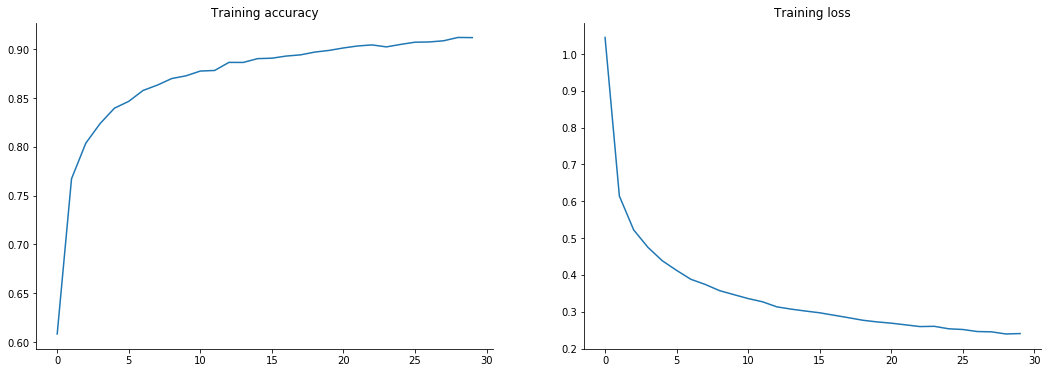

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

accuracy = history.history['acc']
loss = history.history['loss']
epochs = range(len(accuracy))

fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
axarr[0].plot(epochs, accuracy)
axarr[0].set_title('Training accuracy')
sns.despine()

axarr[1].plot(epochs, loss)
axarr[1].set_title('Training loss')
sns.despine()

plt.show()

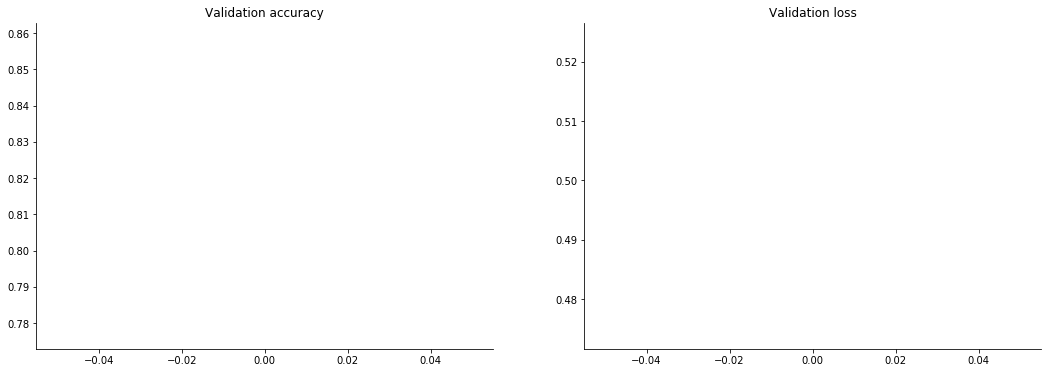

In [12]:
val_accuracy = history.history['val_acc']
val_loss = history.history['val_loss']
epochs = range(len(val_accuracy))

fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
axarr[0].plot(epochs, val_accuracy)
axarr[0].set_title('Validation accuracy')
sns.despine()

axarr[1].plot(epochs, val_loss)
axarr[1].set_title('Validation loss')
sns.despine()

plt.show()

Looks good. Let's see what classes the classifier performed well on and which ones it struggled with.

In [132]:
y_test_pred = clf.predict_classes(X_test)
y_test_classed = np.nonzero(y_test)[1]

In [135]:
from sklearn.metrics import classification_report
print(classification_report(y_test_pred, y_test_classed, target_names=img_class_key.values()))

              precision    recall  f1-score   support

     t-shirt       0.90      0.86      0.88      1281
       pants       0.98      0.99      0.99      1158
    pullover       0.87      0.89      0.88      1172
       dress       0.95      0.88      0.91      1331
        coat       0.86      0.85      0.86      1203
      sandal       0.97      0.99      0.98      1111
       shirt       0.73      0.79      0.76      1140
    sneakers       0.99      0.95      0.97      1266
     handbag       0.99      0.99      0.99      1145
        boot       0.97      0.98      0.98      1193

   micro avg       0.92      0.92      0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



We see here that certain classes are noticeably more distinguishable than others. We scored allmost all pants, sandals, and handbags correctly, indicating that these classes are highly separable. We fared worst on upper body clothing items: pullovers, coats, and especially shirts. None of this is very surprising; the silhouettes of shoes are very easy to tell apart from those of shirts, but amongst the different classes of shirts there's a lot of potential overlap.

Finally to evaluate our model complexity we can inspect which areas of the images the CNN is firing on. The following code snippet courtesy of François Chollet, the original author of Keras, who provides it in his "Deep Learning with Python" book.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


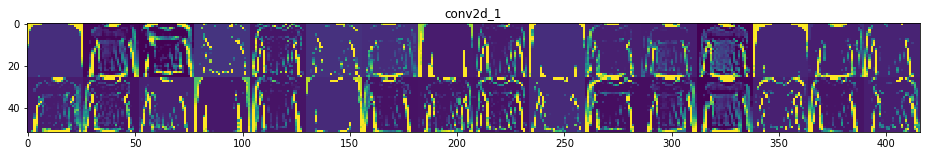

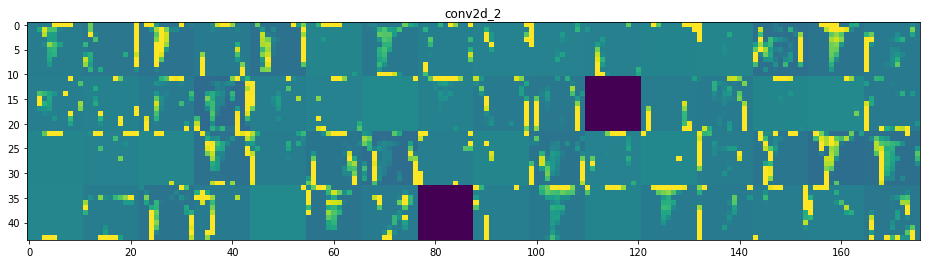

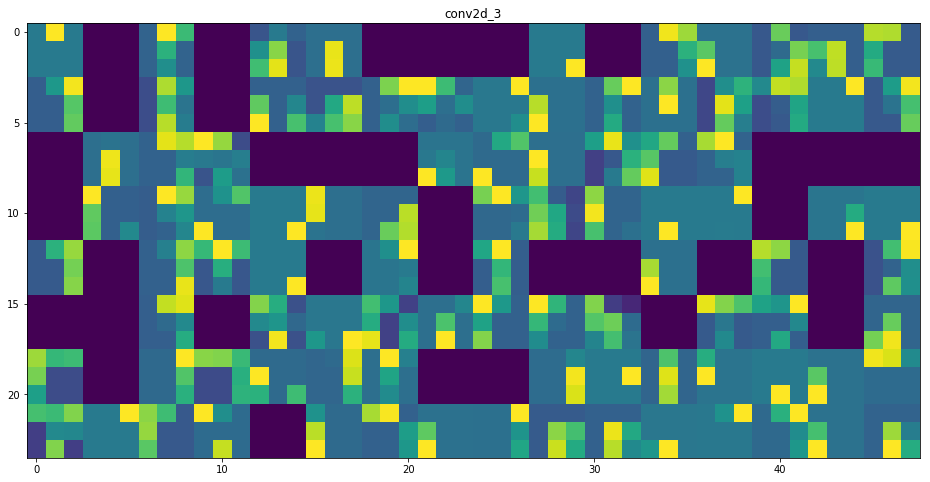

In [155]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

A CNN works by aggregating the features of an image into progressively higher feature pools, so the earlier layers in this visualization are easier to interpret than the later ones. We see that the first layer seems to fire mostly on edges of the image, and on the distinction between foreground and background in the image. The second layer seems to begin to focus on patterns on the article of clothing itself. The third layer is difficult to interpret.

Note that some images are completely blacked out, indicating neurons that did not fire at all. This is because those neurons were deadened by the regularization properties of the ReLU activation layers we are using in this CNN. A significant but not overwhelming percentage of the neurons in our third convolutional layer never fire, indicating relatively good fit of our model architecture to this data: too simple and no neurons will be regulated out; too complex and many more will be.

## Saving the model and data

Now that we have trained a performant neural network it is time to save our work.

We will use [Quilt T4](https://quiltdocs.gitbook.io/t4/) to do so. `t4` allows you to perform version control over data, much like you use `git` to version control your code.

We'll use T4 to create a **data package** containing the following files:
* `clf.h5`, which is our classifier serialized to a `hdf5` file.
* `build.ipynb`, this notebook.
* `quilt_summarize.json`, which will tell the online UI to preview `build.ipynb`.

In [24]:
# save the classifier
clf.save('clf.h5')

In [43]:
# create a simple quilt_summarize.json
with open("quilt_summarize.json", "w") as f:
    f.write('["build.ipynb"]')

To set up the files in a `Package` append to it using `set`.

In [48]:
import t4

p = (t4.Package()
     .set("clf.h5", "clf.h5")
     .set("build.ipynb", "build.ipynb")
     .set("quilt_summarize.json", "quilt_summarize.json")
    )

Then `push` it to T4.

In [49]:
p.push("aleksey/fashion-mnist-clf", "s3://alpha-quilt-storage")

build.ipynb
clf.h5
quilt_summarize.json

This package will now be available (to anyone with access to the `s3://alpha-quilt-storage` bucket) to anyone, using either the `t4` Python package or from within the T4 catalog browser:

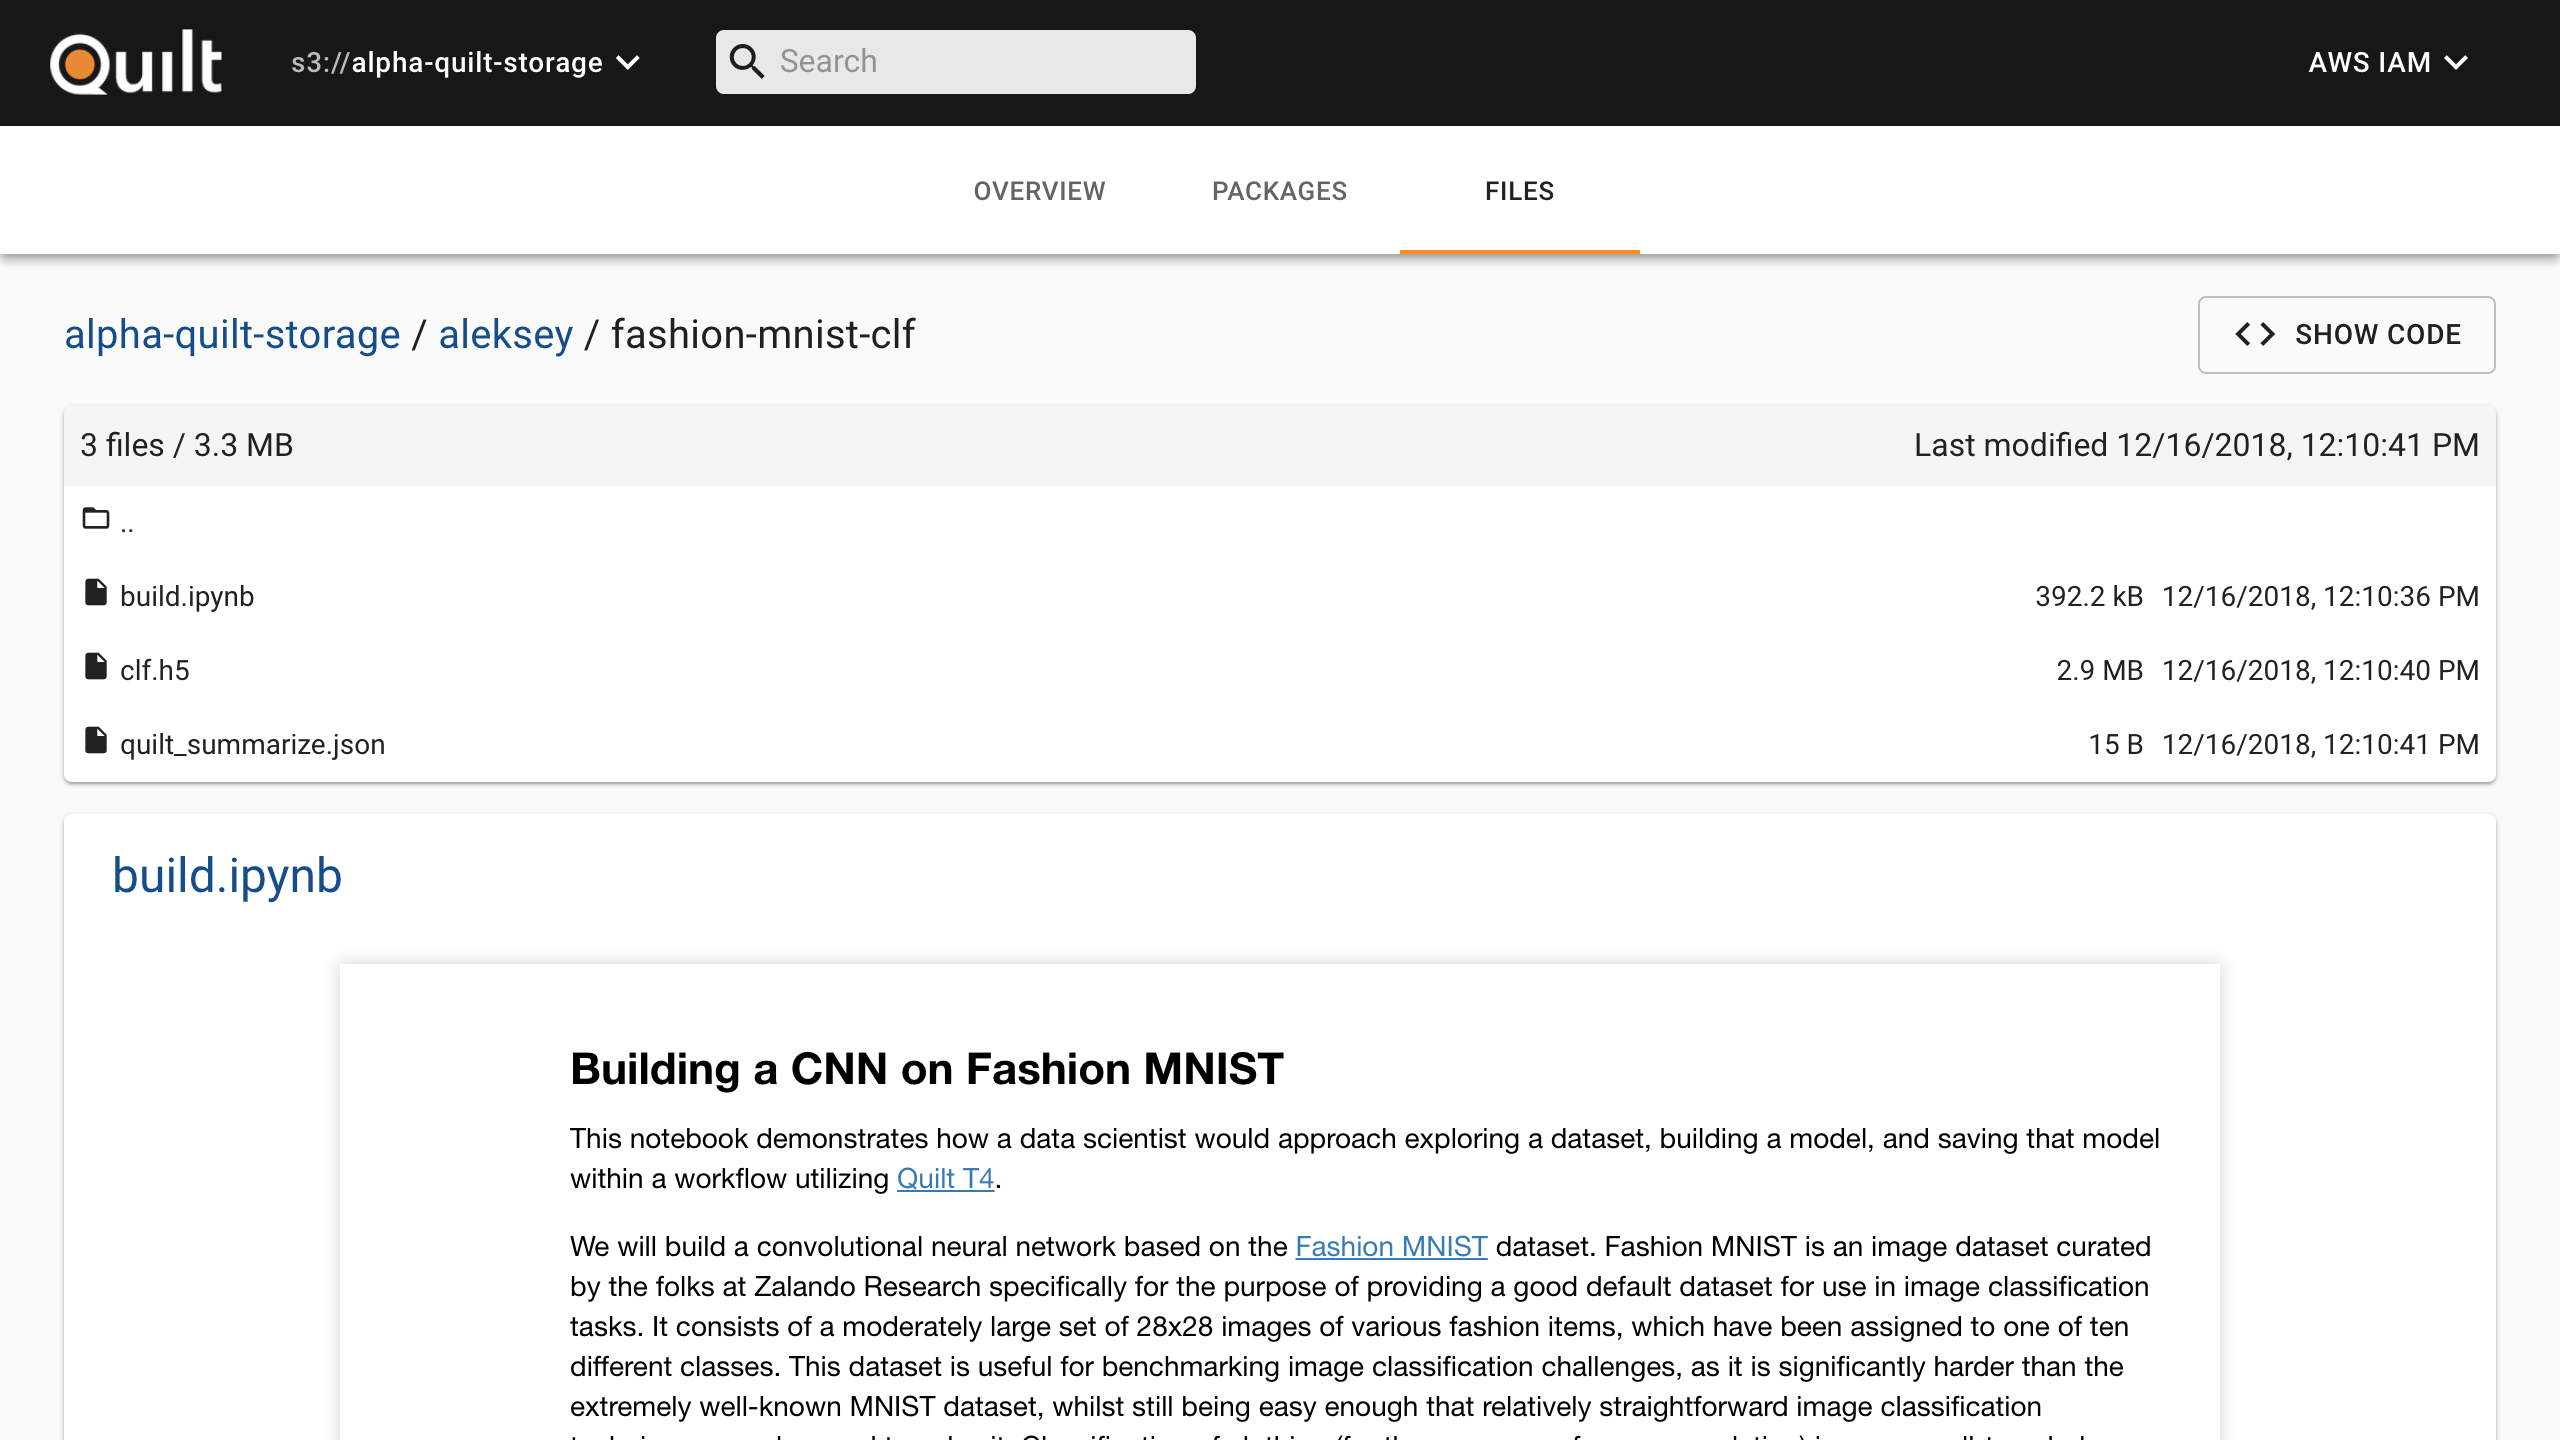

In [47]:
from IPython.display import Image
Image("catalog-screencap.png")